<a href="https://colab.research.google.com/github/jdberkson/OPTI-556-Computational-Imaging/blob/main/FinalProject_JoelBerkson.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Gamma Distortion Correction

In most display systems, whether it be LED screens, projectors, or even cameras, the brightness response is nonlinear compared to the true brightness desired/observed. This is typically represented as a gamma factor $I^\gamma$, where linear response is $\gamma$ = 1. Usually it is beneficial in display systems to have a gamma factor greater than 1, which will look more natural to our eye, but in some systems this is undesirable. If you desire to recover the inital image.

This is the case in any metrology system that utilizes a phase shifting algorithm (PSA). This includes Phase Shifting Interferometers (PSI), Phase Measuring Deflectometry (PMD), Fringe Projection Profilometry (FPP), and others involving phase shifted patterns.

For these systems the ideal pattern takes the form of:

$$
I_n(x) = A+Bsin(\omega_ox+n*2\pi/N+\phi(x)) \tag{Eq. 1}
$$

Where N is the number of phase shifts, and n denotes the nth pattern, $\omega_o$ is the pattern frequency. The goal of a PSA is to recover $\phi(x)$, which effectively encodes the surface under test with a phase, which is then converted to depth/slope information, depending on the metrology method being used. One of the most common ways to recover this phase is through what's known as a the PSA LSQ (Least Squares):

$$
\phi(x,y) = arctan(\frac{\sum_{n=0}^{N} I_n(x,y)sin(2\pi n/N)}{ \sum_{n=0}^{N} I_n(x,y)cos(2\pi n/N) }) \tag{Eq. 2}
$$

This equation effectively least squares fits a point on the fringe pattern, and can perfectly recover the phase, given a perfect input pattern.
This issue is, the pattern never perfect in real life. There's noise, gamma distortion, saturation, etc. In this project, I will only address gamma distortion. by adding the exponential gamma factor to Eq. 1:

$$
I_n(x)^\gamma = (A+Bsin(\omega_ox+n*2\pi/N+\phi(x)))^\gamma \tag{Eq. 3}
$$

Writing this as a fourier series in exponential form:

$$
I_n(x)^\gamma = A+\sum_{k=1}^{\infty}B_ksin(k[\omega_ox+n*2\pi/N+\phi(x))]) \tag{Eq. 4}
$$

This produces the kth harmonic terms with ampltitude $B_k$. When $\gamma \neq 1$, and the phase shited series from Eq. 1 is used with the PSA LSQ in Eq. 2, the resulting phase will have unwanted ripples at the higher freqeuncy harmonics of the original pattern, which will then affect the final measurement.

There are many methods that already exist to remove gamma distortion, but almost all of them involve designing a frequency filter to remove the higher order harmonics from the phase map, but this method doesn't always work perfectly, especially if the fringe frequency varies across the field of view, which is often the case for skewed camera/projector perspectives. My goal is that the gamma value can be estimated by training a CNN on just one image of the fringes at a time, and then the inverse can be applied to recover the fringe pattern $I_{actual} = I_{measured}^{1/\gamma}$


I will use fairly large images to make them more realistic to real camera images (1280x720). Then I will generate training data with the following parameters randomized

1. Fringe period, between some bounds of ~5 fringes to 20 fringes over the image
2. Fringe orientation (clocking)
3. A linear term in x and y added to the fringe period (within some bounds). This would nicely simulate a projector with the fringes at a non-normal incidence with a plane.

The input data to the network will be the above randomized fringe pattern, with an added random gamma factor between 0.8 and 1.8.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Model
import cv2
import math
plt.rcParams['figure.figsize'] = [30, 10]
plt.rcParams.update({'font.size': 22})

In [3]:
def sigmoid(x):
    sig = 1 / (1 + math.exp(-x))
    return sig
def sigmoid_inv(sig):
  x = math.log(sig/(1-sig))
  return x

In [4]:
def createFringePattern(X,Y,fringePeriod,clockingangle,slope):
  
  
  fringePeriodwDistortion = fringePeriod*(1+slope*X)
  Pattern = (0.5+0.5*np.cos(2*np.pi*X/(fringePeriodwDistortion)))
  Pattern = ndimage.rotate(Pattern,clockingangle,reshape=True)
  
  return Pattern[1024:2048,1024:2048]

In [5]:
X = np.linspace(0,3072,num=3072)
Y = np.linspace(0,3072,num=3072)
X,Y = np.meshgrid(X,Y)
fringePeriodBounds = [5, 50]
gammaBounds = [.8, 1.8]
slopeBounds = [0,.002]
N = 200

PatternCorrect = np.zeros([N,1024,1024])
PatternGamma = np.zeros([N,1024,1024])
clockingangle = np.zeros(N)
gamma = np.zeros(N)
gamma_squished = np.zeros(N)
period = np.zeros(N)
slope = np.zeros(N)

for i in range(N):
  clockingangle[i] = np.random.random_sample()*360
  gamma[i] = np.random.random_sample()*(gammaBounds[1]-gammaBounds[0])+gammaBounds[0]
  period[i] = np.random.random_sample()*(fringePeriodBounds[1]-fringePeriodBounds[0])+fringePeriodBounds[0]
  slope[i] = np.random.random_sample()*(slopeBounds[1]-slopeBounds[0])+slopeBounds[0]

  PatternCorrect[i,:,:] = createFringePattern(X,Y,period[i],clockingangle[i],slope[i])
  PatternGamma[i,:,:] = PatternCorrect[i,:,:]**gamma[i]
  gamma_squished[i] = gamma[i]-.8

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in power


In [6]:
print(gamma)
with open('/content/drive/My Drive/FringePatterns.npy', 'wb') as f:
    np.savez(f, PatternCorrect,PatternGamma,gamma)

[1.53394006 0.99623693 1.57420107 0.85908941 1.50787271 1.49765396
 1.12445024 1.26941477 1.23398578 1.04158414 1.5213064  1.25550484
 0.83459321 0.91628319 1.17549592 0.86800824 1.50014475 1.27948039
 1.79095507 1.23454928 1.19248763 0.91024943 1.79233823 1.50847499
 1.05686406 1.57172548 0.9010619  1.45340007 1.51554352 1.71514596
 1.66533546 1.13051842 1.58572462 1.72834431 1.23604639 1.04880148
 1.79634367 1.46049018 1.4607376  1.28267218 1.27041913 0.82841395
 0.82214966 1.17784604 1.48483323 1.63031518 1.57443887 1.4051929
 1.76404394 1.43577124]


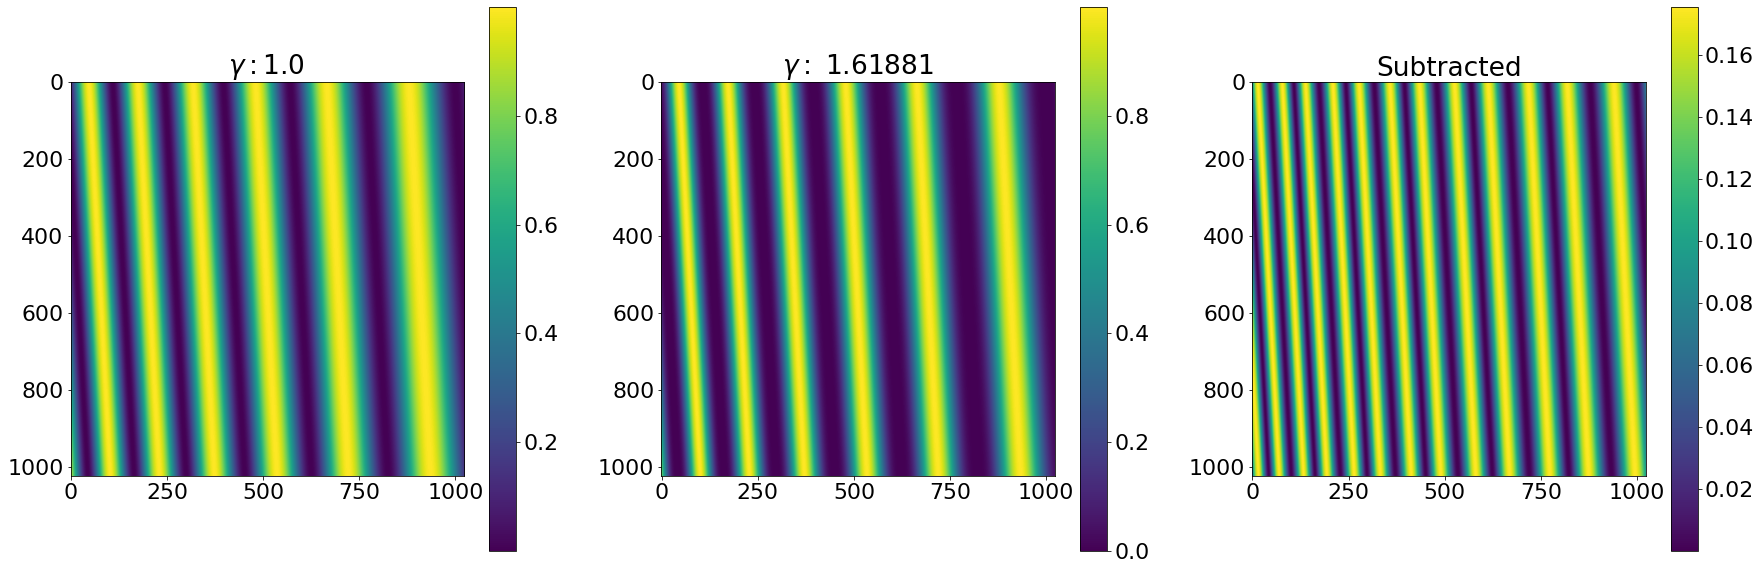

In [ ]:
n = 5
plt.subplot(1,3,1)
plt.imshow(PatternCorrect[n,:,:])
plt.title('$\gamma: 1.0$ ')
plt.colorbar()
plt.subplot(1,3,2)
plt.imshow(PatternGamma[n,:,:])
plt.title('$\gamma:$ ' + str(round(gamma[n],ndigits=5)))
plt.colorbar()
plt.subplot(1,3,3)
plt.imshow(PatternCorrect[n,:,:]-PatternGamma[n,:,:])
plt.title('Subtracted')
plt.colorbar()

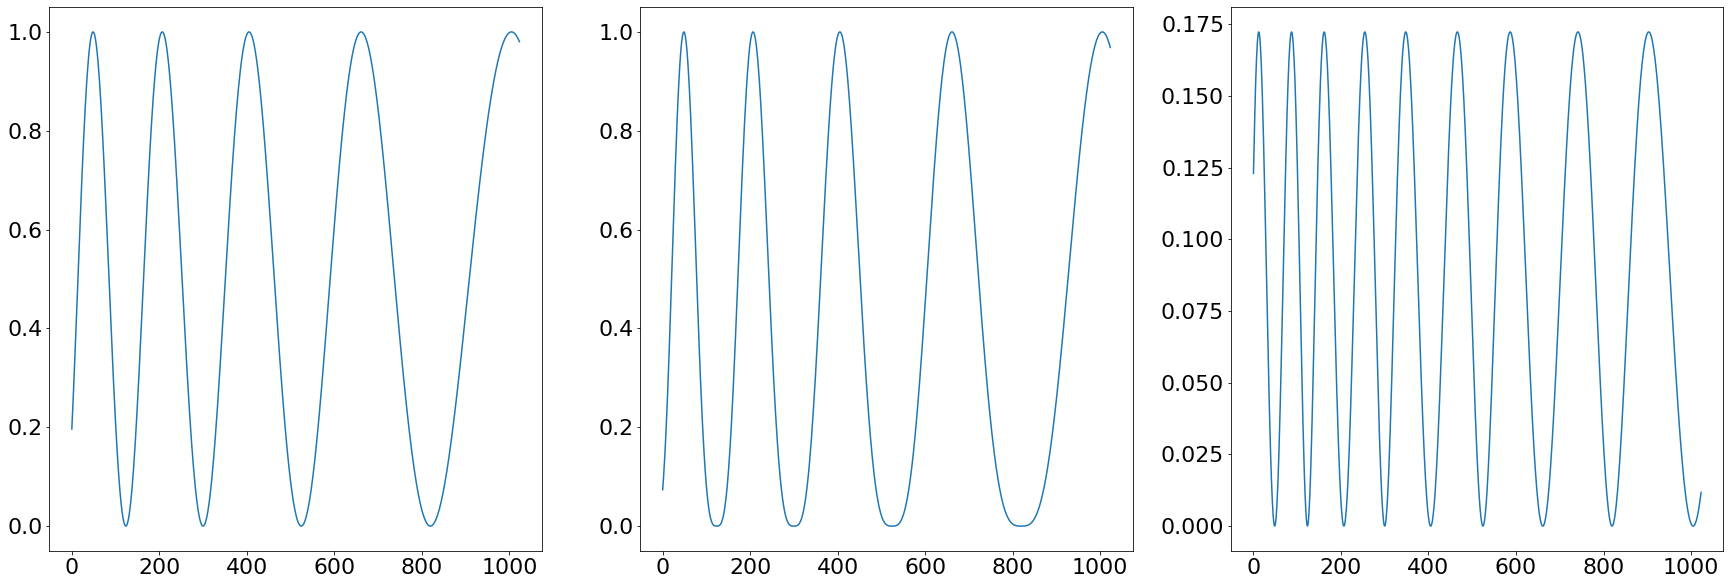

In [ ]:

plt.subplot(1,3,1)
plt.plot(PatternCorrect[n,512,:])
plt.subplot(1,3,2)
plt.plot(PatternGamma[n,512,:])
plt.subplot(1,3,3)
plt.plot(PatternCorrect[n,512,:]-PatternGamma[n,512,:])

In [ ]:
input_img = keras.Input(shape=(1024, 1024, 1))

x = layers.Conv2D(1, (8, 8), strides=4, activation='relu', padding='same')(input_img)
x = layers.Conv2D(1, (8, 8), strides=2, activation='relu', padding='same')(x)
x = layers.Conv2D(1, (8, 8), strides=8, activation='relu', padding='same')(x)

encoded = layers.MaxPooling2D((16, 16), padding='same')(x)

autoencoder1 = keras.Model(input_img, encoded)
autoencoder1.compile(optimizer='adam', loss='mean_squared_error')
autoencoder1.summary()

Model: "model_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_29 (InputLayer)       [(None, 1024, 1024, 1)]   0         
                                                                 
 conv2d_162 (Conv2D)         (None, 256, 256, 1)       65        
                                                                 
 conv2d_163 (Conv2D)         (None, 128, 128, 1)       65        
                                                                 
 conv2d_164 (Conv2D)         (None, 16, 16, 1)         65        
                                                                 
 max_pooling2d_32 (MaxPoolin  (None, 1, 1, 1)          0         
 g2D)                                                            
                                                                 
Total params: 195
Trainable params: 195
Non-trainable params: 0
____________________________________________________________

In [ ]:
autoencoder1.fit(
    x=PatternGamma,
    y=gamma,
    epochs=20,
    batch_size=20,
    shuffle=True,
    validation_data=(PatternGamma, gamma),
)

Epoch 1/20
1/1 [==============================] - 1s 672ms/step - loss: 0.2150 - val_loss: 0.1562
Epoch 2/20
1/1 [==============================] - 1s 606ms/step - loss: 0.1562 - val_loss: 0.1040
Epoch 3/20
1/1 [==============================] - 1s 600ms/step - loss: 0.1040 - val_loss: 0.0927
Epoch 4/20
1/1 [==============================] - 1s 592ms/step - loss: 0.0927 - val_loss: 0.1292
Epoch 5/20
1/1 [==============================] - 1s 605ms/step - loss: 0.1292 - val_loss: 0.1634
Epoch 6/20
1/1 [==============================] - 1s 606ms/step - loss: 0.1634 - val_loss: 0.1523
Epoch 7/20
1/1 [==============================] - 1s 604ms/step - loss: 0.1523 - val_loss: 0.1165
Epoch 8/20
1/1 [==============================] - 1s 592ms/step - loss: 0.1165 - val_loss: 0.0921
Epoch 9/20
1/1 [==============================] - 1s 595ms/step - loss: 0.0921 - val_loss: 0.0921
Epoch 10/20
1/1 [==============================] - 1s 594ms/step - loss: 0.0921 - val_loss: 0.1069
Epoch 11/20
1/1 [==

In [ ]:
for i in range(N):
  a = autoencoder1.predict(PatternGamma[i:i+1,:,:])
 
  print((a))
  print(gamma[i])

[[[[1.1196877]]]]
1.0329577453069776
[[[[1.2481353]]]]
1.5547418066558787
[[[[1.2413309]]]]
0.8775300181881265
[[[[1.0840416]]]]
0.8478394126600467
[[[[1.427459]]]]
1.2226900239403373
[[[[1.316065]]]]
1.1866298660847618
[[[[1.3752133]]]]
0.8385627234448639
[[[[1.2649165]]]]
1.0377554780927838
[[[[1.300897]]]]
1.5786468139681662
[[[[1.343663]]]]
1.545750411722452
